# HSE Start ML Kaggle competition 
---
https://www.kaggle.com/competitions/start-ml-classic-track/overview

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA, KernelPCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline

import glob
from google.colab import drive
drive.mount('/gdrive', force_remount=True)



Mounted at /gdrive


In [2]:
from tqdm import tqdm

dirname = "/gdrive/My Drive/HSE_START_ML/ML_track/ML_track_train"

X, y = [], []


for fname in tqdm(os.listdir(dirname)):
    img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)
    y.append(int(fname.split('label')[1].split('.png')[0]))
        
    h, w = img.shape
    size = min(h, w)
    h0 = int((h - size) / 2)
    w0 = int((w - size) / 2)
        
    img = img[h0: h0 + size, w0: w0 + size]
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
        
    X.append(img)    

len(X), len(y)

100%|██████████| 313/313 [00:03<00:00, 88.71it/s] 


(313, 313)

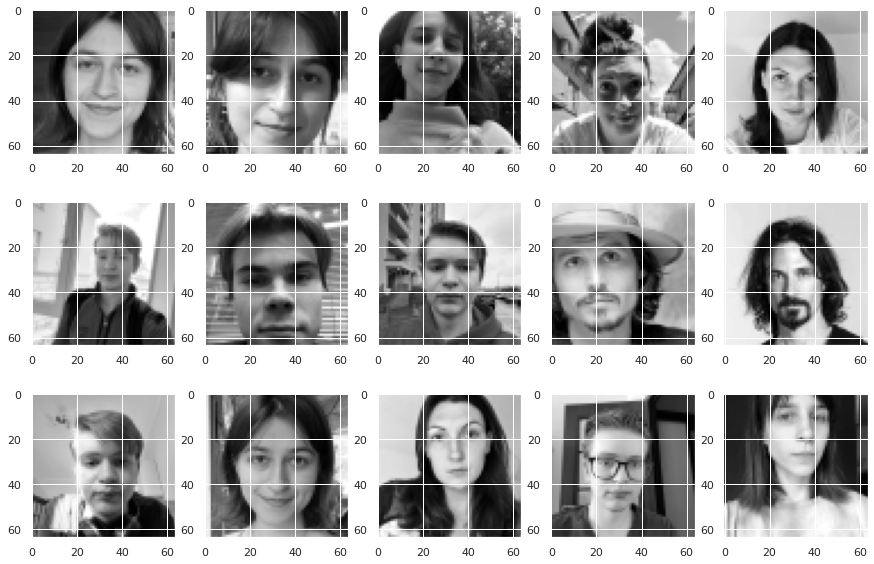

In [3]:
fig, axx = plt.subplots(3, 5, figsize=(15, 10))

for i in range(3):
  for j in range(5):
    img = X[i*5+j]
    axx[i][j].imshow(img, cmap='gray')

In [4]:
import random
import albumentations as A


from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def get_aug(image):

    angle = np.arange(-10,11,1)
    angle0 = random.choice(angle)

    shift = 0.02*np.arange(-10,11,1)
    shift0 = random.choice(shift)

    transform = A.Compose([
        A.HorizontalFlip(p=0.4),
        A.GaussNoise(var_limit=(85, 120), p=0.3),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=6, p=0.5),
            A.Blur(blur_limit=6, p=0.5),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0, rotate_limit=13, p=0.2),
    ])
    
    random.seed(47) 

    return transform(image=image)['image']

In [5]:
XAug, yAug = [], [] 

for (a,b) in zip(X,y):
    for i in range(10):
      XAug.append(get_aug(a))
      yAug.append(b)

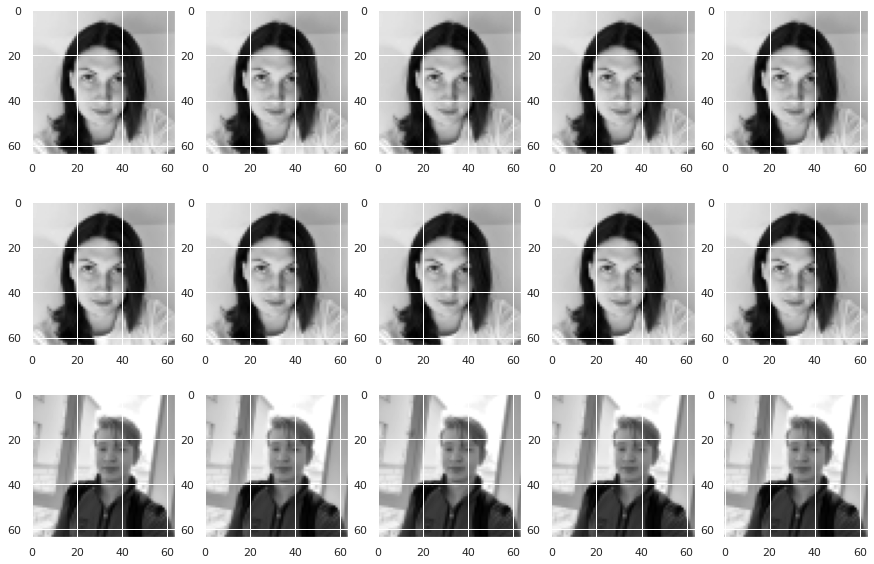

In [6]:
fig, axx = plt.subplots(3, 5, figsize=(15, 10))

for i in range(3):
  for j in range(5):
    img = XAug[i*5+j+40]
    axx[i][j].imshow(img, cmap='gray')

In [7]:
face_detected_counter = 0 
XAugC,yAugC, XAugNoC, yAugNoC = [], [], [], []

cascade_versions = [
        'haarcascade_frontalface_alt2.xml',
        'haarcascade_frontalface_alt.xml',
        'haarcascade_frontalface_default.xml',
    ]


    
for img, label in tqdm((zip(XAug, yAug))):
    for version in cascade_versions:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + version)
        face = face_cascade.detectMultiScale(img, minSize=(1,1), maxSize=(64,64),  scaleFactor=1.01,minNeighbors=2)
        if len(face) != 0:
            break
        
    for (a, b, w, h) in face:
        face = img[b: b+h, a: a+w]
    try:
        h, w = face.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)

        img = face[h0: h0 + size, w0: w0 + size]
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

        XAugC.append(img)
        yAugC.append(label)
        face_detected_counter += 1

    except:
        XAugNoC.append(img)
        yAugNoC.append(label)

print('')
print(f'detected {face_detected_counter} of {len(XAug)} faces – {face_detected_counter/len(XAug)*100:.2f}%')        

3130it [02:16, 22.90it/s]


detected 2880 of 3130 faces – 92.01%


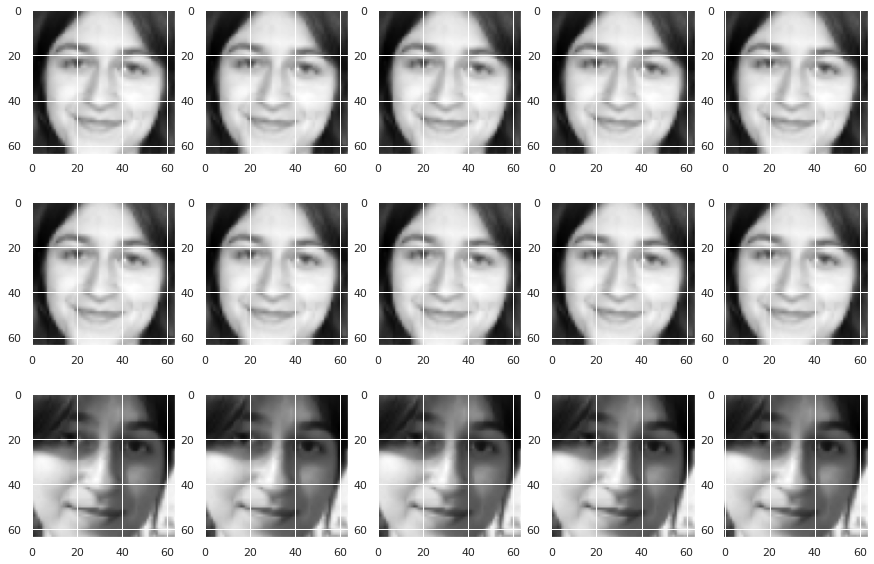

In [8]:
fig, axx = plt.subplots(3, 5, figsize=(15, 10))

for i in range(3):
  for j in range(5):
    img = XAugC[i*5+j]
    axx[i][j].imshow(img, cmap='gray')

In [9]:
from skimage.feature import hog

def get_hog_features(images): 
    ppcr = 8
    ppcc = 8
    hog_images = []
    hog_features = []
    for image in tqdm(images):
      blur = image
      fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(ppcr,ppcc),cells_per_block=(2,2),block_norm= 'L2-Hys',visualize=True)
      hog_images.append(hog_image)
      hog_features.append(fd)
    hog_features = np.array(hog_features)
    hog_features.shape
    return hog_features

In [10]:
XAugC = get_hog_features(XAugC)
XAugNoC = get_hog_features(XAugNoC)

100%|██████████| 250/250 [00:02<00:00, 90.66it/s]


In [11]:
cv = 10

In [12]:
Cascaed_svm_model = SVC(kernel = 'linear')

scores = cross_val_score(Cascaed_svm_model, XAugC, yAugC, cv=cv)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 accuracy with a standard deviation of 0.04


In [13]:
Not_cascaed_svm_model = SVC(kernel = 'linear')

scores = cross_val_score(Not_cascaed_svm_model, XAugNoC, yAugNoC, cv=cv)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


In [14]:
def sort_by_index(fname):
    return int(fname.split('.')[0].split('image')[1])

In [15]:
from tqdm import tqdm

dirname = "/gdrive/My Drive/HSE_START_ML/ML_track/ML_track_test"

face_detected_counter = 0
XtestC, NamesC = [], []
XtestNoC, NamesNoC = [], []

for fname in tqdm(sorted(os.listdir(dirname), key=sort_by_index)):   
    img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    for version in cascade_versions:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + version)
        face = face_cascade.detectMultiScale(img, minSize=(1,1), maxSize=(64,64),  scaleFactor=1.01,minNeighbors=2)
        if len(face) != 0:
            break
        
    for (a, b, w, h) in face:
        face = img[b: b+h, a: a+w]
    try:
        h, w = face.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)

        img = face[h0: h0 + size, w0: w0 + size]
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

        XtestC.append(img)
        NamesC.append(fname)
        face_detected_counter += 1

    except:
        XtestNoC.append(img)
        NamesNoC.append(fname)



print('')
print(f'detected {face_detected_counter} of {len(os.listdir(dirname))} faces – {face_detected_counter/len(os.listdir(dirname))*100:.2f}%')        

100%|██████████| 2090/2090 [02:18<00:00, 15.05it/s]



detected 1896 of 2090 faces – 90.72%


In [16]:
XtestC = get_hog_features(XtestC)
XtestNoC = get_hog_features(XtestNoC)

100%|██████████| 194/194 [00:02<00:00, 90.56it/s]


In [17]:
Cascaed_svm_model.fit(XAugC, yAugC)
Not_cascaed_svm_model.fit(XAugNoC, yAugNoC)

SVC(kernel='linear')

In [18]:
Cascade_prediction = Cascaed_svm_model.predict(XtestC)
Not_Cascade_prediction = Not_cascaed_svm_model.predict(XtestNoC)

In [19]:
def sort_by_file_index_pd(pred_df):
  numbers = []
  for word in pred_df:
    numbers.append(int(word.split('.')[0].split('image')[1]))
  return numbers

In [20]:
import pandas as pd

pred_df = pd.DataFrame(list(zip(NamesC, Cascade_prediction)), columns = ['img_name', 'pred_class'])
pred_NoC = pd.DataFrame(list(zip(NamesNoC, Not_Cascade_prediction)), columns = ['img_name', 'pred_class'])
pred_df = pred_df.append(pred_NoC, ignore_index = True).sort_values(by='img_name', key= sort_by_file_index_pd)



In [21]:
pred_df[0:20]

,img_name,pred_class
0,image0.png,7
1,image1.png,3
2,image2.png,4
3,image3.png,5
4,image4.png,0
5,image5.png,2
6,image6.png,3
7,image7.png,5
8,image8.png,9
9,image9.png,8


In [22]:
pred_df.to_csv("submission.csv", index=False)

Competition results:

Private Score: 0.76459

Public Score: 0.72440